In [3]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
import pickle
from scipy.optimize import curve_fit

## Virtualization
import matplotlib.pyplot as plt
import seaborn as sns

## res settings
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 10

## Clustering
from sklearn.mixture import GaussianMixture

RANDOM_STATE = 4000
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_pickle("data/train_sc.data")
data.head()

,Lithology,Porosity,Formation Resistivity Factor,EQI
0,carbonate,0.265580,50.247750,0.273743
1,carbonate,0.135722,339.767716,0.147260
2,carbonate,0.201896,109.309208,0.212867
3,carbonate,0.153623,172.815822,0.194080
4,carbonate,0.170026,158.653403,0.192538


In [5]:
data = data[data['Lithology'] == 'carbonate']
data.describe()

,Porosity,Formation Resistivity Factor,EQI
count,2143.000000,2143.000000,2143.000000
mean,0.134141,130.119809,0.313387
std,0.068958,112.040798,0.106178
min,0.023121,5.791307,0.103618
25%,0.072931,58.031920,0.236440
50%,0.123294,100.761458,0.301215
75%,0.182916,167.992776,0.372191
max,0.453092,1603.522546,0.846085


In [6]:
x= np.c_[data.values,np.ones(len(data))]

In [7]:
def modelGenerator(max_, eqi_array):
    n_components = np.arange(2, max_)
    models = [np.array(GaussianMixture(n, covariance_type='tied', random_state=RANDOM_STATE).fit_predict(eqi_array.reshape(-1, 1)))
              for n in n_components]
    return models

In [8]:
def power_law(x, a, m):
    return a*np.power(x, m)

def values_and_rquared(model_predictions, mask, x):
    absError = model_predictions - x[mask, :][:,2]
    Rsquared = 1.0 - (np.var(absError) / np.var(x[mask, :][:,2]))
    return Rsquared

def modelGenerator(max_, eqi_array):
    n_components = np.arange(2, max_)
    models = [np.array(GaussianMixture(n, covariance_type='tied', random_state=RANDOM_STATE).fit_predict(eqi_array.reshape(-1, 1)))
              for n in n_components]
    return models

def variance_calculator(models, x):
    m_variances = []
    r2_variances = []
    m_parameters = []
    r2_parameters = []
    for j in range(0, len(models)):
        
        n = len(np.unique(models[j]))
        m_var = 0
        r2_var = 0 
        m_parameters[:] = []
        r2_parameters[:] = []
        x[:,4] = models[j]
        no_regression = 0
        for i in np.unique(models[j]):
            
            mask = x[:, 4] == i
            if (not (len(x[mask, :]) <= 2)):
                
                popt, _ = curve_fit(power_law, x[mask, :][:,1], x[mask, :][:,2])
                # summarize the parameter values
                a, m = popt
                m_parameters.append(abs(m))
                modelPredictions = power_law(x[mask, :][:,1], a, m)
                r2_parameters.append(values_and_rquared(modelPredictions, mask, x))
                
            else:
                no_regression += 1
                continue
        
        m_var = np.var(m_parameters)
        r2_var = np.var(r2_parameters)
        m_variances.append(m_var)
        r2_variances.append(r2_var)
        print('For ', n, ' ERTs, the m var is ', m_var, ' and the R2 var is ', r2_var,
              ' and has ', no_regression, ' ERT(s) containing less than 3 members' )
        if (m_var <= 0.001 and r2_var <= 0.001):
            print('Optimum number of clusters is ', n)
            break
    return [m_variances, r2_variances]

In [9]:
%%time
models = modelGenerator(100, x[:,3])
[mVariances, r2Variances] = variance_calculator(models, x)

For  2  ERTs, the m var is  0.06678497072512042  and the R2 var is  0.09932921400009712  and has  0  ERT(s) containing less than 3 members
For  3  ERTs, the m var is  0.04760179740232485  and the R2 var is  0.05723562061405248  and has  0  ERT(s) containing less than 3 members
For  4  ERTs, the m var is  0.012263195537164404  and the R2 var is  0.02792661935021759  and has  0  ERT(s) containing less than 3 members
For  5  ERTs, the m var is  0.002981505689270092  and the R2 var is  0.02392560004945756  and has  0  ERT(s) containing less than 3 members
For  6  ERTs, the m var is  0.0021657671447247906  and the R2 var is  0.02276568636940422  and has  0  ERT(s) containing less than 3 members
For  7  ERTs, the m var is  0.03547244839480502  and the R2 var is  0.007557277406034748  and has  0  ERT(s) containing less than 3 members
For  8  ERTs, the m var is  0.005253451928482894  and the R2 var is  0.017285025977479565  and has  0  ERT(s) containing less than 3 members
For  9  ERTs, the m 

In [23]:
def testModel(data, n):
    _R2s = []
    _ms=[]
    _as=[]
    cl_model = GaussianMixture(n_components = n, covariance_type='tied', random_state=RANDOM_STATE)
    clusters= cl_model.fit_predict(data['EQI'].values.reshape(-1, 1))
    data['ERTs'] = clusters + 1
    sub_df = data[data.groupby('ERTs').ERTs.transform('count')>2].copy()
    withdrewnERT = data[data.groupby('ERTs').ERTs.transform('count') <= 2]
    for i in np.sort(pd.unique(sub_df['ERTs'])):
        popt, _ = curve_fit(power_law, sub_df[sub_df['ERTs'] == i]['Porosity'],  sub_df[sub_df['ERTs'] == i]['Formation Resistivity Factor'])
        # summarize the parameter values
        a, b = popt
        _ms.append(b)
        _as.append(a)
        model_predictions = power_law(sub_df[sub_df['ERTs'] == i]['Porosity'], a,b)
        absError = model_predictions - sub_df[sub_df['ERTs'] == i]['Formation Resistivity Factor']
        Rsquared = 1.0 - (np.var(absError) / np.var(sub_df[sub_df['ERTs'] == i]['Formation Resistivity Factor']))
        _R2s.append(Rsquared)
        print('ERT ', i, ': F = %.5f * φ ^ %.5f' % (a, b))
        print('R-squared:', Rsquared)
    
    print(data.groupby('ERTs').describe()[['EQI']])
    if len(withdrewnERT) == 0:
        print('There is no clusters with less than 3 components')
    else:
        print('clusters with less than 3 samples: \n',withdrewnERT['ERTs'])
        
    return [_as, _ms, _R2s, sub_df]

In [24]:
_as, _ms, _R2s, sub_df = testModel(data, 44)

ERT  1 : F = 12.06396 * φ ^ -0.99382
R-squared: 0.997996995822126
ERT  2 : F = 4.91082 * φ ^ -1.02357
R-squared: 0.9993107710720696
ERT  3 : F = 29.45226 * φ ^ -0.97277
R-squared: 0.9791108044472391
ERT  4 : F = 3.40369 * φ ^ -1.00812
R-squared: 0.99915564308431
ERT  5 : F = 6.97793 * φ ^ -1.00736
R-squared: 0.9990063126075098
ERT  6 : F = 2.28524 * φ ^ -0.96441
R-squared: 0.9928981364094892
ERT  7 : F = 15.61657 * φ ^ -0.99783
R-squared: 0.9973452027744089
ERT  8 : F = 11.01777 * φ ^ -0.99877
R-squared: 0.9981364383774293
ERT  9 : F = 8.84140 * φ ^ -0.99133
R-squared: 0.9992682446663215
ERT  10 : F = 20.07377 * φ ^ -0.99541
R-squared: 0.9970465238863188
ERT  11 : F = 36.58532 * φ ^ -1.02801
R-squared: 0.9443248141370306
ERT  12 : F = 1.57633 * φ ^ -0.95595
R-squared: 0.9696859588630579
ERT  13 : F = 5.88767 * φ ^ -0.99529
R-squared: 0.9984694784294312
ERT  14 : F = 3.88656 * φ ^ -1.00063
R-squared: 0.9994545331241499
ERT  15 : F = 1.91339 * φ ^ -0.94901
R-squared: 0.9958363234386227
E

In [25]:
def plotFvsPhi(sub_df, n, _ms, _as):
    mpl.rcParams['figure.dpi']= 700
    sns.set_palette(sns.color_palette("BrBG", n))
    for count, i in enumerate(list(np.sort(pd.unique(sub_df['ERTs'])))):
        sns.lineplot(x=sub_df[sub_df['ERTs'] == i]['Porosity'], y= _as[count] * sub_df[sub_df['ERTs'] == i]['Porosity'] ** (_ms[count]),
                    linestyle='--')  #, marker='o'
        sns.scatterplot(x=sub_df[sub_df['ERTs'] == i]['Porosity'], y= sub_df[sub_df['ERTs'] == i]['Formation Resistivity Factor'],
                            linewidths=2, edgecolor='black', label = str(i)) 
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(bbox_to_anchor=(0., -0.25, 1., .102), loc='upper left',
               ncol=4, mode="expand")
    plt.xlabel('Porosity')
    plt.ylabel('Formation Resistivity Factor')
    plt.show()


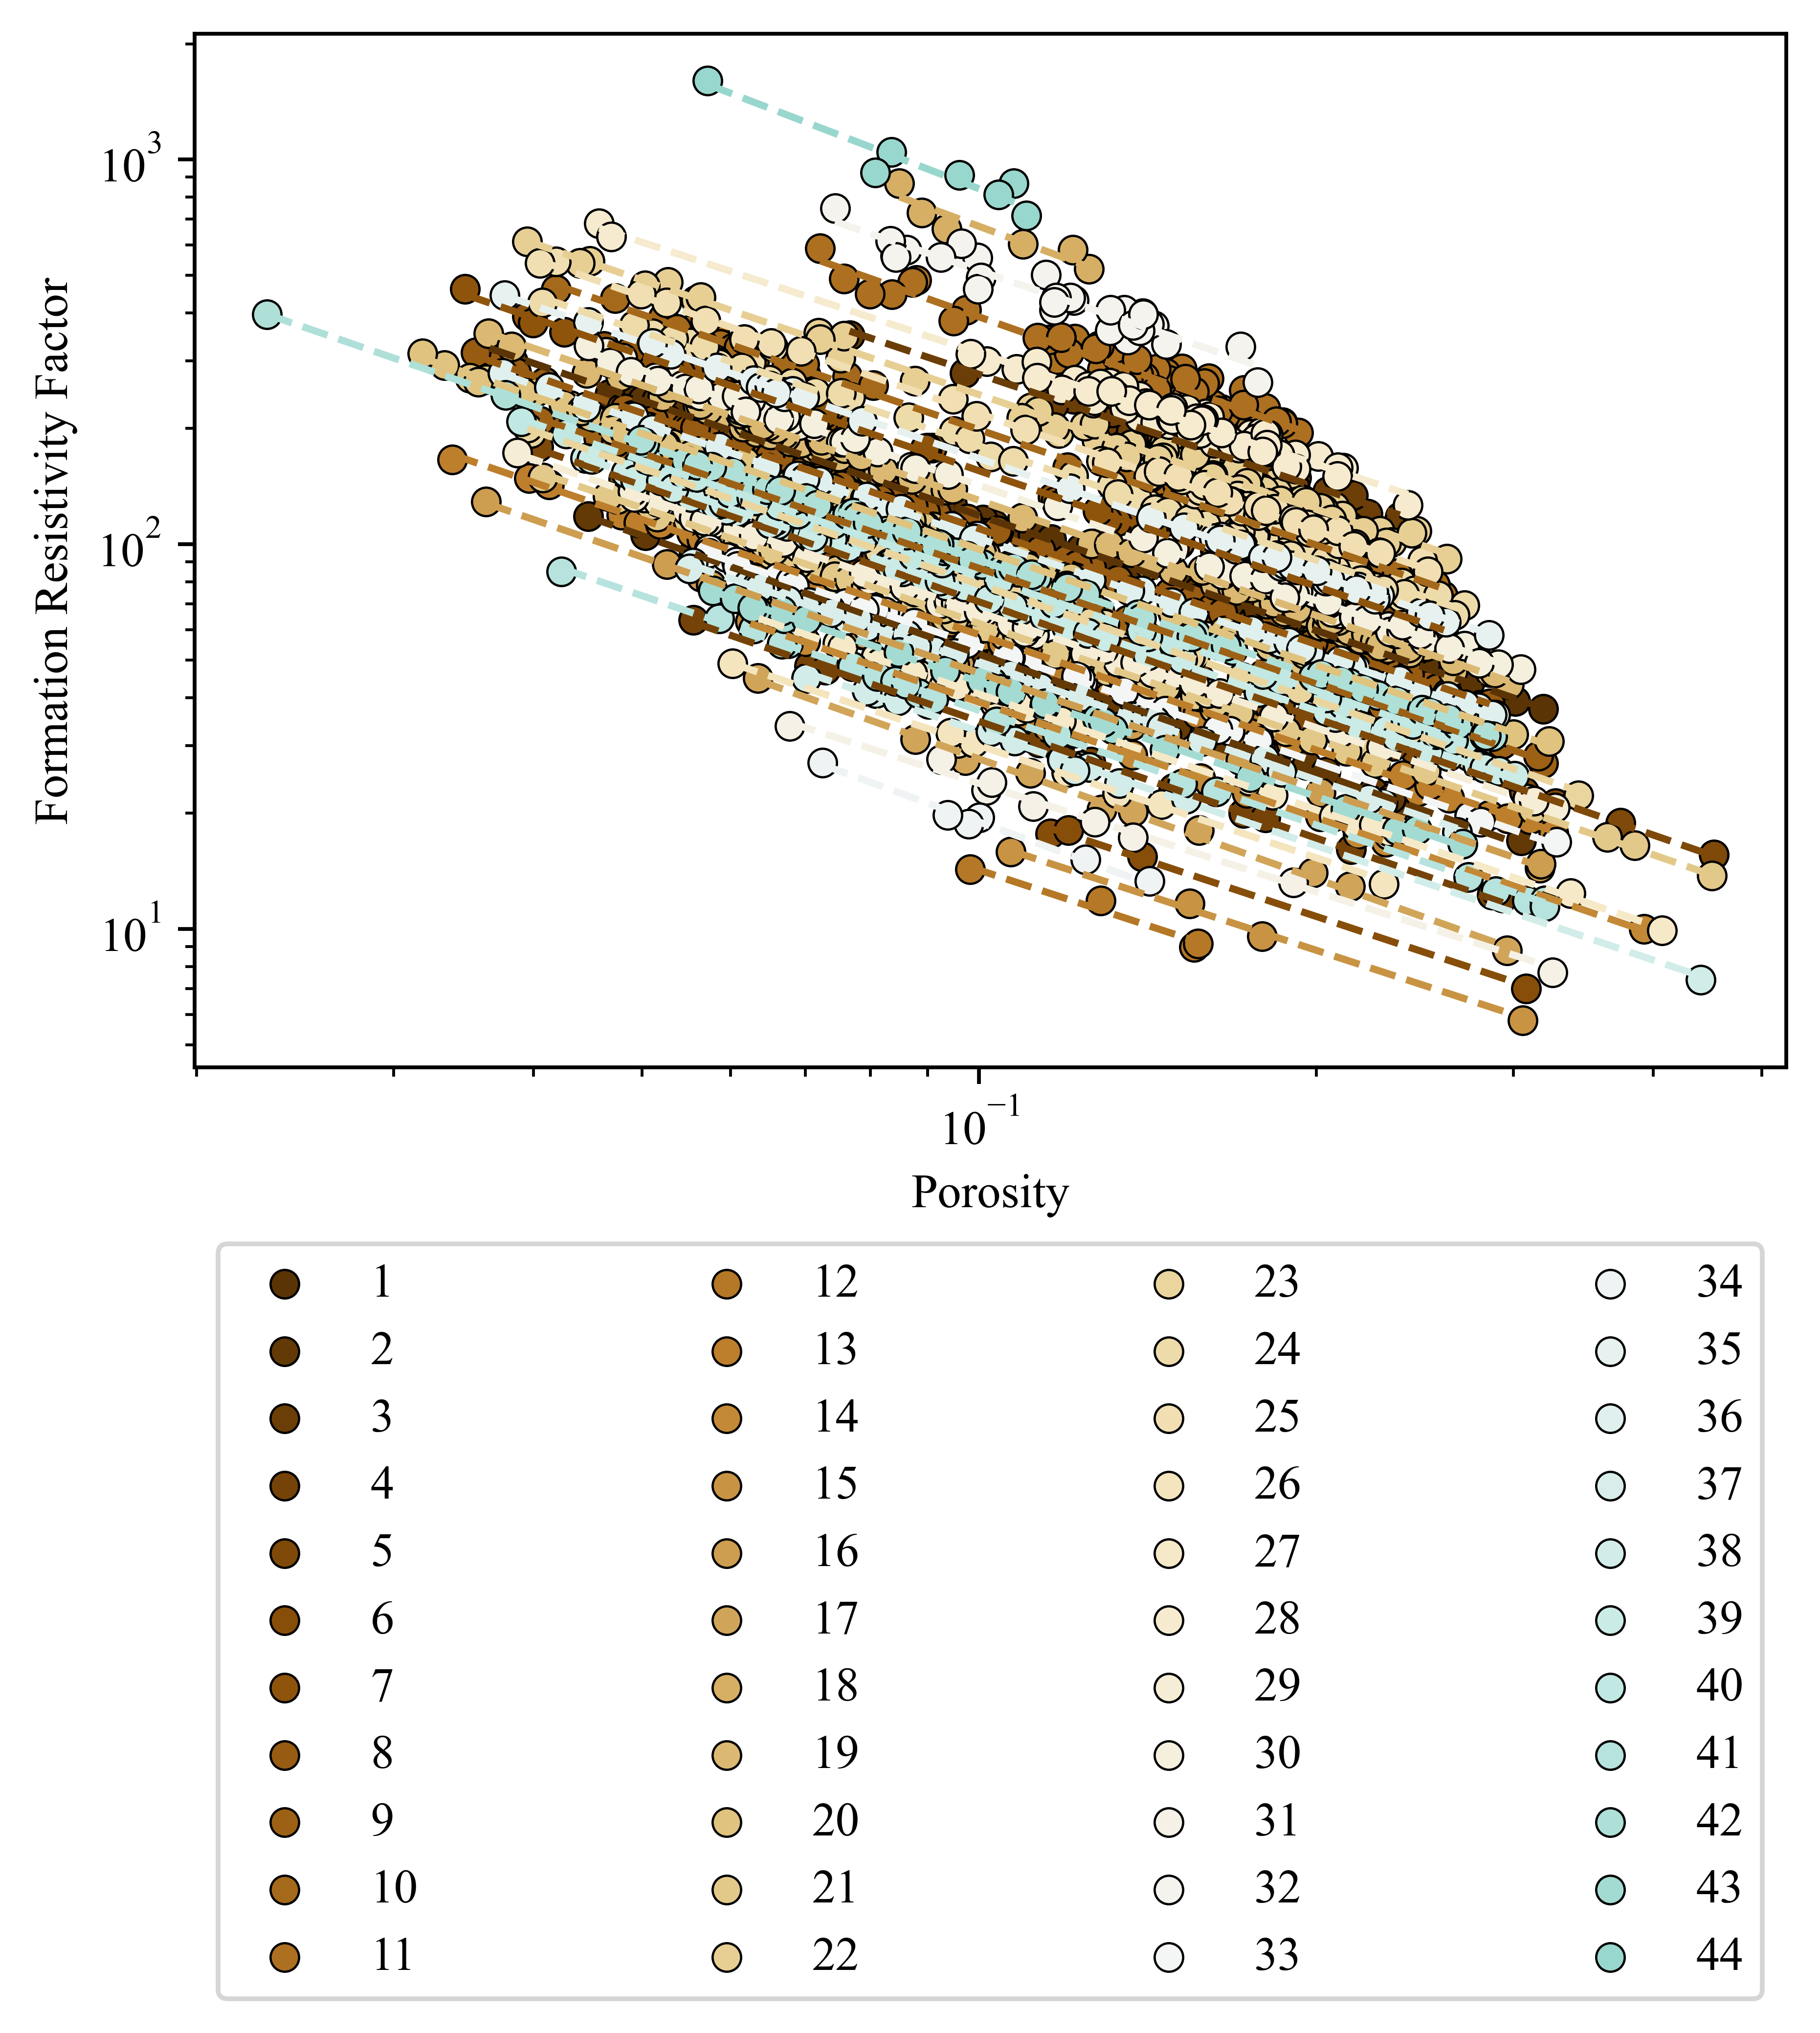

In [26]:
plotFvsPhi(sub_df, 65, _ms, _as)

In [34]:
result = {'ERT': list(np.sort(pd.unique(sub_df['ERTs']))),
        'total': list(sub_df.groupby('ERTs').count()['EQI']),
        'min': list(sub_df.groupby('ERTs').describe()['EQI']['min'].T),
        'max': list(sub_df.groupby('ERTs').describe()['EQI']['max'].T),
        'a': _as,
        'm': _ms,
        'r2': _R2s,
       }

resultsDf = pd.DataFrame(result)
resultsDf

,ERT,total,min,max,a,m,r2
0,1,86,0.284436,0.295434,12.063959,-0.993820,0.997997
1,2,35,0.433841,0.445010,4.910823,-1.023565,0.999311
2,3,44,0.184173,0.193464,29.452258,-0.972766,0.979111
3,4,14,0.531426,0.541478,3.403688,-1.008122,0.999156
4,5,55,0.371055,0.380448,6.977930,-1.007358,0.999006
5,6,4,0.678085,0.698054,2.285235,-0.964414,0.992898
6,7,95,0.248485,0.259251,15.616570,-0.997832,0.997345
7,8,97,0.295712,0.306990,11.017771,-0.998767,0.998136
8,9,56,0.335053,0.344012,8.841405,-0.991330,0.999268
9,10,84,0.218578,0.229793,20.073775,-0.995406,0.997047


In [35]:
sub_df['m'] = - (np.log10(sub_df['Formation Resistivity Factor']) / np.log10(sub_df['Porosity']))

In [43]:
def linear(x, a, b):
    return a * x + b
def mVsPhiRelation(sub_df): 
    _R2s = []
    _bs=[]
    _as=[]
    for i in np.sort(pd.unique(sub_df['ERTs'])):
        popt, _ = curve_fit(linear, sub_df[sub_df['ERTs'] == i]['Porosity'],  sub_df[sub_df['ERTs'] == i]['m'])
        # summarize the parameter values
        a, b = popt
        _bs.append(b)
        _as.append(a)
        modelPredictions = linear(sub_df[sub_df['ERTs'] == i]['Porosity'], a,b)
        absError = modelPredictions - sub_df[sub_df['ERTs'] == i]['m']
        Rsquared = 1.0 - (np.var(absError) / np.var(sub_df[sub_df['ERTs'] == i]['m']))
        _R2s.append(Rsquared)
        print('ERT ', i, ': m = %.5f * φ + %.5f' % (a, b))
        print('R-squared:', Rsquared)
    return [np.sort(pd.unique(sub_df['ERTs'])), _as, _bs, _R2s]

In [44]:
ERT, _as2, _bs, _R2s2 = mVsPhiRelation(sub_df)

ERT  1 : m = 4.80308 * φ + 1.58895
R-squared: 0.9984844893145358
ERT  2 : m = 3.12650 * φ + 1.39923
R-squared: 0.9981841404437507
ERT  3 : m = 6.23989 * φ + 1.82028
R-squared: 0.9922396239961234
ERT  4 : m = 2.49087 * φ + 1.28736
R-squared: 0.9981823866549264
ERT  5 : m = 4.07953 * φ + 1.43888
R-squared: 0.991821771065257
ERT  6 : m = 1.58159 * φ + 1.16524
R-squared: 0.9941712004229176
ERT  7 : m = 5.25700 * φ + 1.65741
R-squared: 0.9984201401800415
ERT  8 : m = 4.59084 * φ + 1.57638
R-squared: 0.9987857716752077
ERT  9 : m = 4.24491 * φ + 1.51002
R-squared: 0.9983181961276163
ERT  10 : m = 5.70465 * φ + 1.71894
R-squared: 0.9978346557685691
ERT  11 : m = 6.72821 * φ + 1.91572
R-squared: 0.9749459137720784
ERT  12 : m = 0.63174 * φ + 1.09652
R-squared: 0.45436677251388247
ERT  13 : m = 3.44652 * φ + 1.41574
R-squared: 0.9972844402814908
ERT  14 : m = 2.86388 * φ + 1.29561
R-squared: 0.9933090538644742
ERT  15 : m = 1.21437 * φ + 1.11029
R-squared: 0.9847915772947528
ERT  16 : m = 3.032

In [45]:
result_linear = {
        'ERTs': ERT,
        'a': _as2,
        'b': _bs,
        'r2': _R2s2
       }

result_linearDf = pd.DataFrame(result_linear)
result_linearDf

,ERTs,a,b,r2
0,1,4.803078,1.588955,0.998484
1,2,3.126499,1.399232,0.998184
2,3,6.239886,1.820276,0.992240
3,4,2.490870,1.287360,0.998182
4,5,4.079527,1.438876,0.991822
5,6,1.581590,1.165239,0.994171
6,7,5.257000,1.657406,0.998420
7,8,4.590838,1.576381,0.998786
8,9,4.244914,1.510019,0.998318
9,10,5.704649,1.718936,0.997835


In [48]:
test_df = pd.read_pickle("data/test.data")
test_df['mc'] = - (np.log10(test_df['Formation Resistivity Factor']) / np.log10(test_df['Porosity']))
test_df = test_df[test_df['Lithology'] == 'carbonate']
test_df

,Lithology,Porosity,Formation Resistivity Factor,EQI,mc
108,carbonate,0.181658,120.209852,0.213995,2.807897
623,carbonate,0.227663,76.460948,0.239681,2.930480
1746,carbonate,0.168193,33.117951,0.423706,1.963418
978,carbonate,0.070587,89.178609,0.398572,1.694003
813,carbonate,0.119207,35.493429,0.486155,1.678198
875,carbonate,0.068655,101.419507,0.378967,1.724473
250,carbonate,0.230140,68.126842,0.252549,2.873502
1086,carbonate,0.163655,52.235508,0.342021,2.185511
1448,carbonate,0.064702,126.185730,0.349973,1.766921
817,carbonate,0.065352,58.741258,0.510388,1.493102


In [50]:
mini = sub_df.groupby('ERTs').describe()['EQI']['min']
maxi = sub_df.groupby('ERTs').describe()['EQI']['max']
test_eqi = []
ERT = []
for _test_sample in list(test_df['EQI']):
    i = 1
#     while not i in sub_df.index:
#         i += 1
    while not mini[i]<= _test_sample <= maxi[i]:
        i += 1
        if i > 43:
            i = 0
            break
        while not i in sub_df.groupby('ERTs').describe().index:
            i += 1
            if i > 43 :
                i = 0
                break
    print('Yes', i)
    test_eqi.append(_test_sample)
    ERT.append(i)

test_df['ERTs'] = ERT

Yes 25
Yes 24
Yes 33
Yes 21
Yes 27
Yes 5
Yes 7
Yes 9
Yes 40
Yes 14
Yes 0
Yes 24
Yes 1
Yes 42
Yes 19
Yes 0
Yes 13
Yes 23
Yes 5
Yes 9
Yes 8
Yes 10
Yes 7
Yes 22
Yes 23
Yes 7
Yes 7
Yes 7
Yes 24
Yes 0
Yes 20
Yes 33
Yes 19
Yes 0
Yes 11
Yes 28
Yes 3
Yes 23
Yes 39
Yes 19
Yes 24
Yes 8
Yes 20
Yes 35
Yes 28
Yes 9
Yes 23
Yes 22
Yes 40
Yes 35


In [54]:
m_predicted = []
for i in range(0, 50):
    x = int(test_df.iloc[[i]]['ERTs'])
    if (x != 0):
        p = float(test_df.iloc[[i]]['Porosity'])
        a = float(result_linearDf[result_linearDf['ERTs'] == x]['a'])
        b = float(result_linearDf[result_linearDf['ERTs'] == x]['b'])
        m = a * p + b
        m_predicted.append(m)
    else:
        m_predicted.append(0)
print(m_predicted)
test_df['ma'] = 0.681
test_df['mp'] = m_predicted

[2.809873565786985, 2.9558797214259425, 1.959835665003205, 1.6774918423385148, 1.663106820637261, 1.7189582143376365, 2.8672503937841016, 2.20472122059793, 1.7694880173391787, 1.4827713624068315, 0, 2.8158468749121, 2.6286593637885085, 1.759728419603721, 2.678939411325148, 0, 1.6630567921608, 1.6424251324004262, 1.7363913935462199, 1.77538710355127, 3.1850073281073463, 2.613987703470893, 2.869071670970659, 2.9585028068672647, 1.7028260965066155, 2.2990489892001142, 2.5532713024831986, 1.9599816742807752, 2.828290863001198, 0, 1.7813831968588016, 1.8157649101299433, 2.5931739249319956, 0, 2.9039044643642438, 2.9330491934978733, 3.030094483865609, 1.6507435759367033, 1.8769476993492376, 1.956442306279641, 2.9615965572136305, 1.9175069675312544, 1.7306842332651238, 2.6175022114028863, 2.827837770693935, 1.9008538571335374, 2.2337326632351924, 2.8313556581785484, 1.705003555682742, 2.066656473859053]


In [57]:
def linear_model_results(y_actual, y_prediction, color,k):
    linear_model = LinearRegression().fit(y_actual.values.reshape(-1, 1), y_prediction.values.reshape(-1, 1))
    r_sq = linear_model.score(y_actual.values.reshape(-1, 1), y_prediction.values.reshape(-1, 1))
    print('coefficient of determination:', r_sq)
    print('coef_:', linear_model.coef_)
    print('intercept:', linear_model.intercept_)
    
    
    plt.xlim(0, 3.5)
    plt.ylim(0, 4)
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, color='r', lw=1.5, scalex=False, scaley=False)
    
    sns.scatterplot(x=y_actual, y= y_prediction,
                            linewidths=2, edgecolor='black', color = color) 
    
    
    plt.xlabel('Actual m')
    if k==1:
        plt.ylabel('Predicted m \n (Considering all samples in one cluster)')
    else:
        plt.ylabel('Predicted m (EQI model)')
    plt.show()

coefficient of determination: 0.0
coef_: [[1.22433812e-31]]
intercept: [0.681]


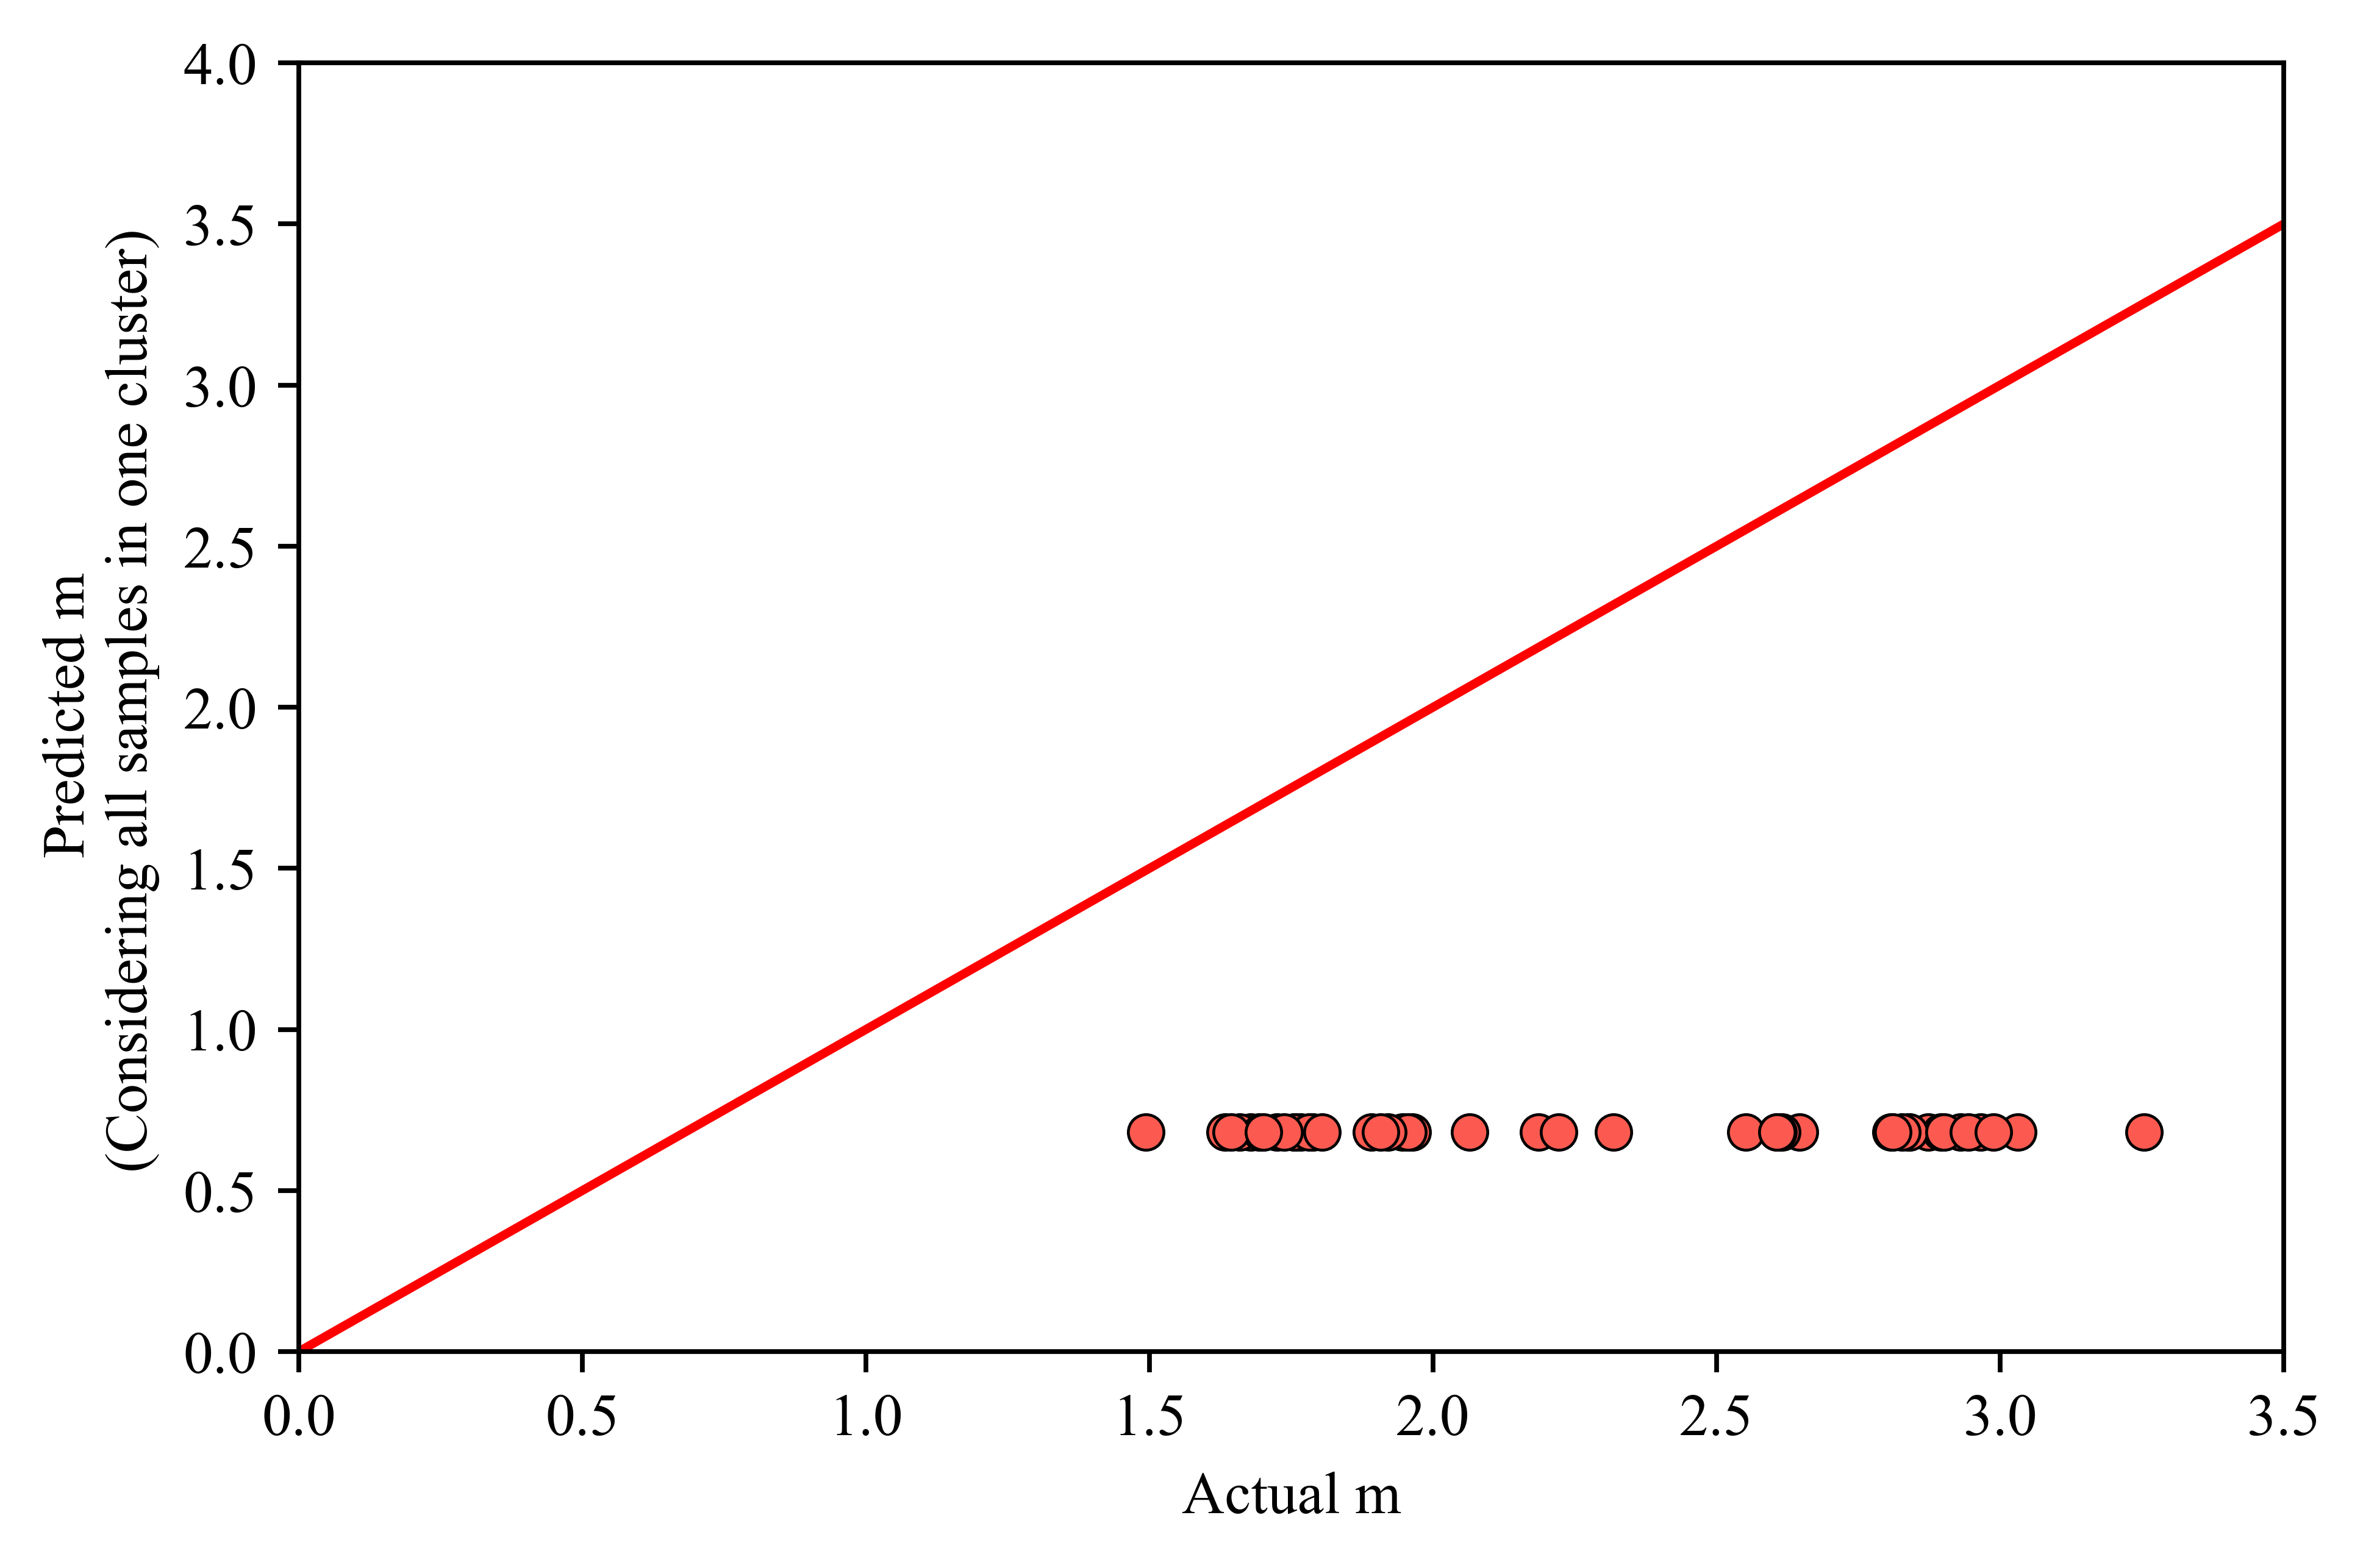

In [62]:
from sklearn.linear_model import LinearRegression
linear_model_results(test_df[test_df['ERTs'] != 0].mc, test_df[test_df['ERTs'] != 0].ma, '#FC5A50',1)

coefficient of determination: 0.9990231108351985
coef_: [[0.99474701]]
intercept: [0.00943085]


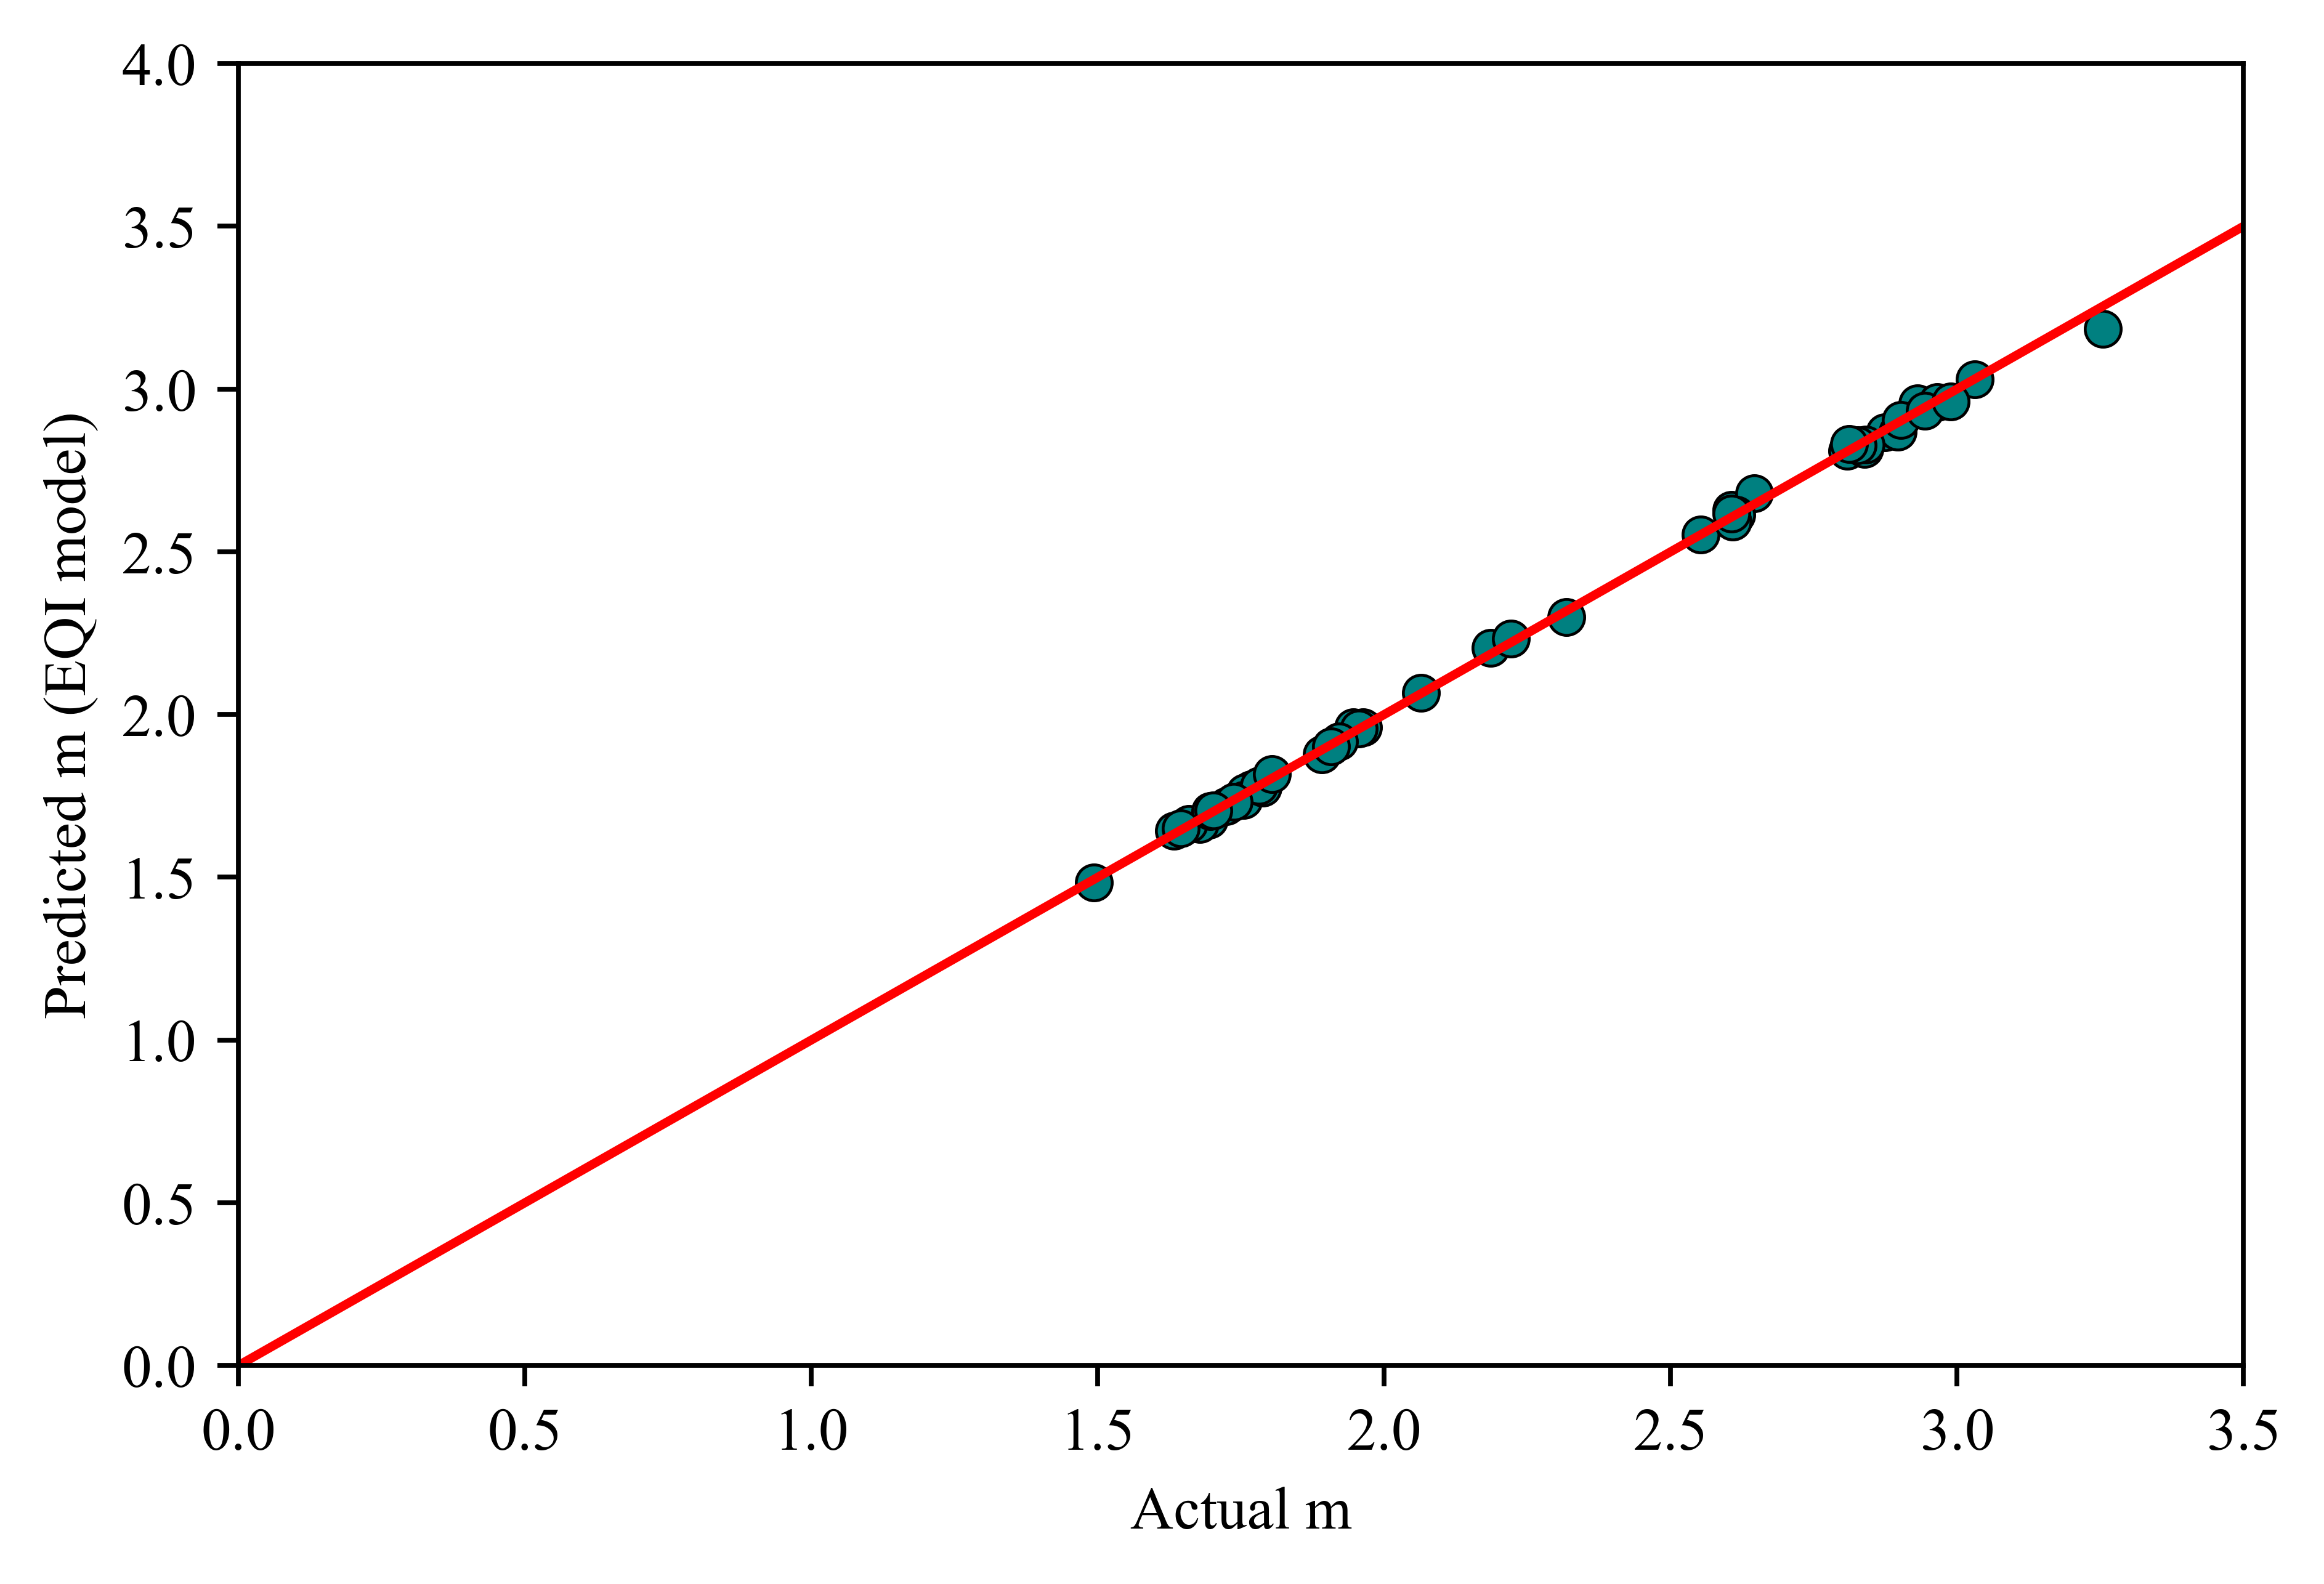

In [61]:
linear_model_results(test_df[test_df['ERTs'] != 0].mc, test_df[test_df['ERTs'] != 0].mp, '#008080',2)